In [1]:
#R Script for Project#
library(TSA)

data=read.csv("MooseData.csv",header=T)       #Read in data#
names(data)=c("year", "fairbanksPop", "mooseHarvest", "totalMoose", "avgSnow", "wolfPop") #Name Columns#

years=data[,"year"] 
ts_fairbanksPop=ts(data[,"fairbanksPop"],start=1965, freq=1)
ts_mooseHarvest=ts(data[,"mooseHarvest"],start=1965, freq=1)
ts_totalMoose=ts(data[,"totalMoose"],start=1965, freq=1)
ts_avgSnow=ts(data[,"avgSnow"],start=1965, freq=1)
ts_wolfPop=ts(data[,"wolfPop"],start=1965, freq=1)


Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar



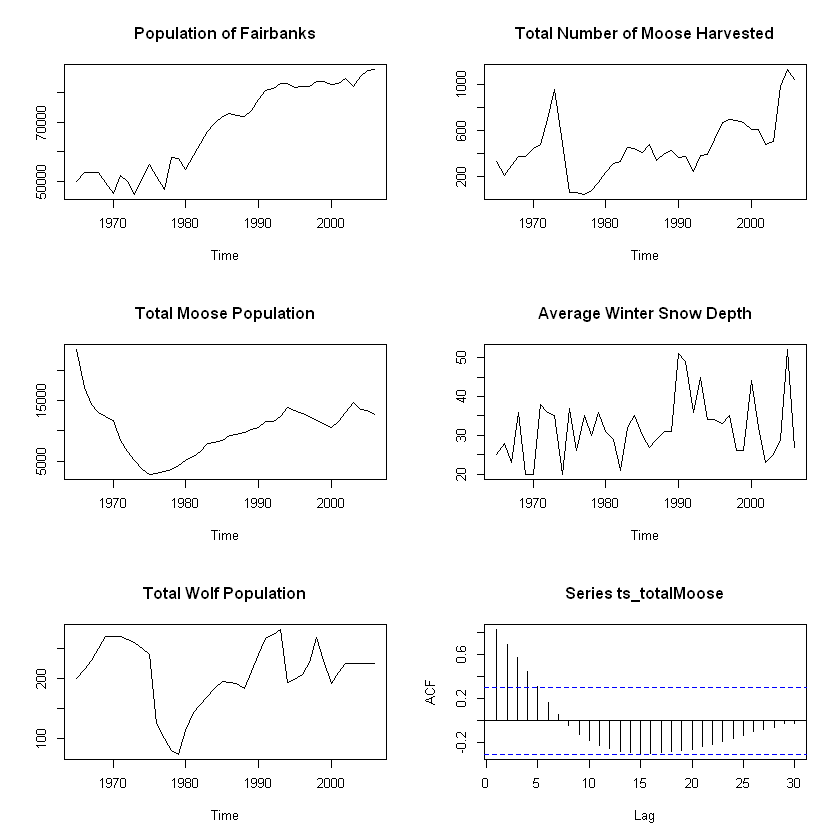

In [2]:
#Plots the 6 ts#
par(mfrow=c(3,2))
plot(ts_fairbanksPop, type="l", main=paste("Population of Fairbanks"),ylab="")
plot(ts_mooseHarvest, type="l", main=paste("Total Number of Moose Harvested"),ylab="")
plot(ts_totalMoose, type="l", main=paste("Total Moose Population"),ylab="")
plot(ts_avgSnow, type="l", main=paste("Average Winter Snow Depth"),ylab="")
plot(ts_wolfPop, type="l", main=paste("Total Wolf Population"),ylab="")
acf(ts_totalMoose, lag.max=30)

# Approach 1: detrend using GAM

remove trend by using GAM regression and plot residual series (detrended series)

In [3]:
## Fit Trend 
library(mgcv)
totalMoose = data[,"totalMoose"]
time.pts = c(1:length(totalMoose))
time.pts = c(time.pts - min(time.pts))/max(time.pts)
gam.fit.tr = gam(totalMoose~s(time.pts))
moose.fit.gam = fitted(gam.fit.tr)
moose.fit.gam = ts(moose.fit.gam,start=1965, freq=1)
resid.process = totalMoose-moose.fit.gam
resid.process = ts(resid.process,start=1965, freq=1)

Warning message:
"package 'mgcv' was built under R version 3.6.3"Loading required package: nlme
Warning message:
"package 'nlme' was built under R version 3.6.3"This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.


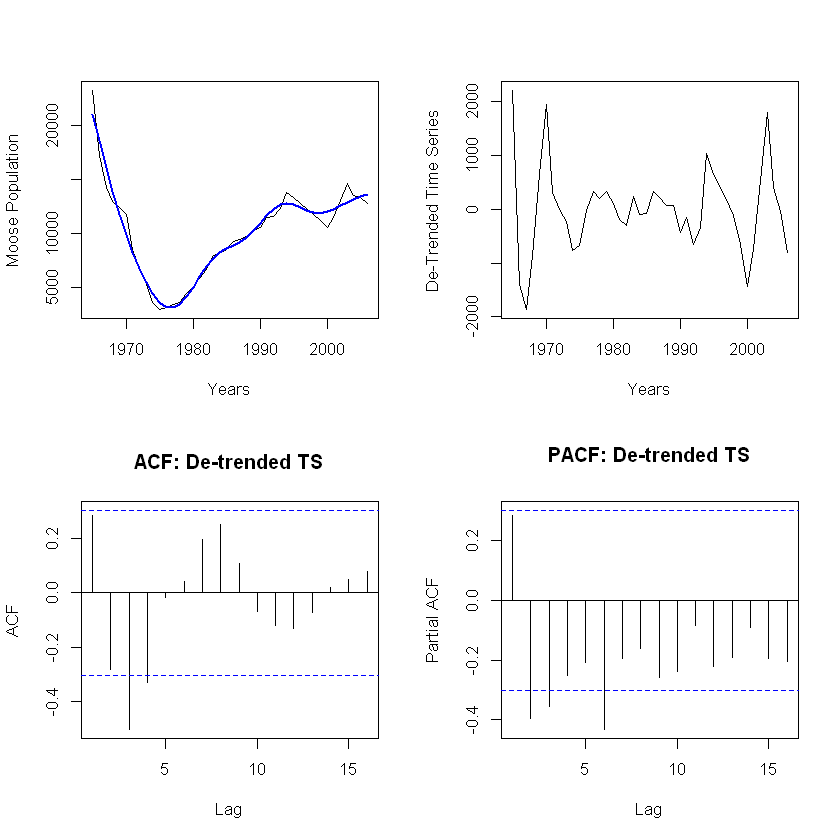

In [4]:
par(mfrow=c(2,2))
plot(ts_totalMoose,xlab="Years",ylab="Moose Population",type="l")
lines(moose.fit.gam,lwd=2,col="blue")
plot(resid.process,xlab="Years",ylab="De-Trended Time Series",type="l")
acf(resid.process,main="ACF: De-trended TS")
pacf(resid.process,main="PACF: De-trended TS")

looking at ACF plot decaying fast The residual process (detrended time series) seems stationary. Now we can apply ARMA on it.

Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] 2
[1] 3


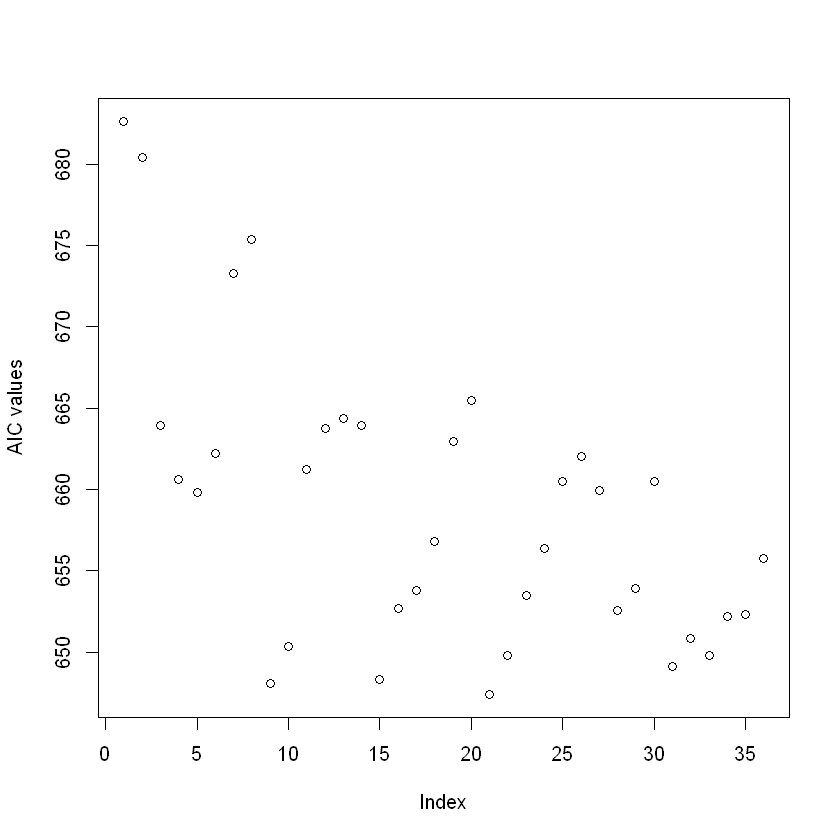

In [5]:
## Order selection -- AIC 
n = length(resid.process)
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)
for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(resid.process,order = c(p[i],0,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
 }

aicv = as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1

print(porder)
print(qorder)

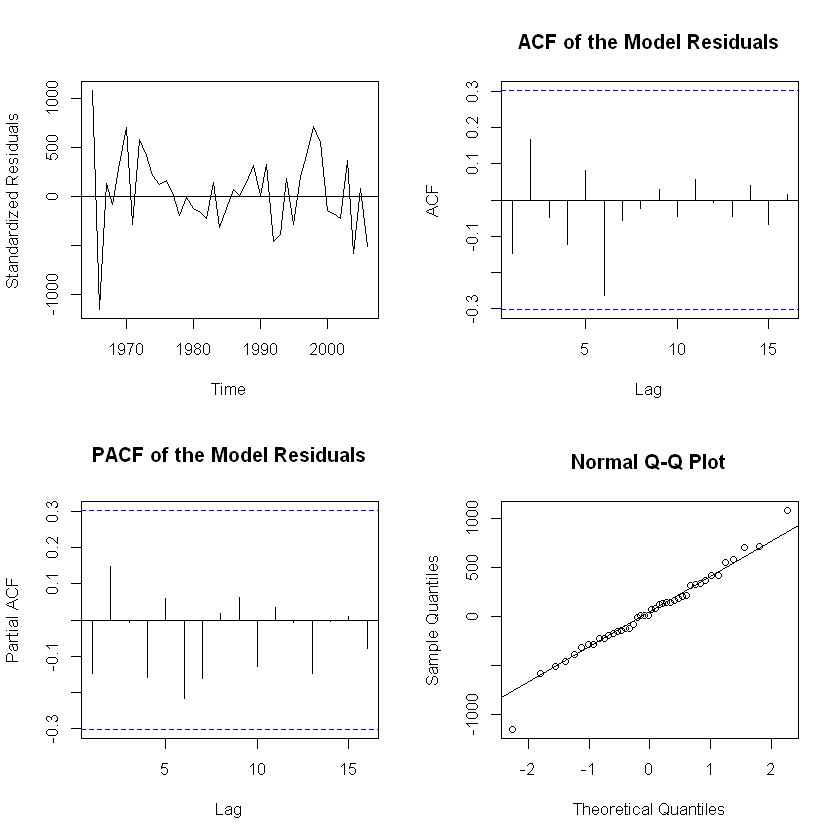

In [6]:
## Fit ARMA Model on detrended series
final_model.1 = arima(resid.process,order = c(porder,0,qorder), method='ML')
resids.1 = resid(final_model.1)
## Residual Analysis
par (mfrow=c(2,2))
plot(resids.1, ylab='Standardized Residuals')
abline(h=0)
acf(resids.1,main= 'ACF of the Model Residuals')
pacf(resids.1,main='PACF of the Model Residuals')
qqnorm(resids.1)
qqline(resids.1)

In [7]:
Box.test(resids.1, lag = (porder+qorder+1), fitdf = (porder+qorder))


	Box-Pierce test

data:  resids.1
X-squared = 6.0056, df = 1, p-value = 0.01426


Both plots and Box test indicate a white noise at 1% confidence.

## Forecasting

In [8]:
## Forecasting Trend+ARMA: 4 years ahead
n = length(resid.process)
nfit = n-4

## Predict trend
train.totalMoose= totalMoose[1:nfit]
x = time.pts[1:nfit]
gam.fit.tr.4 = gam(train.totalMoose~s(x))
newdata = data.frame(x=time.pts[(nfit+1):n])
gam.pred= predict(gam.fit.tr.4,newdata = newdata,interval=c("prediction"))

In [9]:
## Detrend to obtain residual/detrended process.
resid.process.4 = totalMoose[1:nfit]-fitted(gam.fit.tr.4)
resid.process = ts(resid.process.4,start=1965, freq=1)
outresid = arima(resid.process.4, order = c(porder,0,qorder),method = "ML")
outpredresid = predict(outresid,n.ahead=4)$pred
final.pred.1 = outpredresid+gam.pred

# Approach 2: Here we remove the trend using Differencing

In [10]:
## Order selection -- AIC  taking differencing d in ARIMA as 1
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)
for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(ts_totalMoose,order = c(p[i],1,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
}

Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

[1] 1
[1] 0


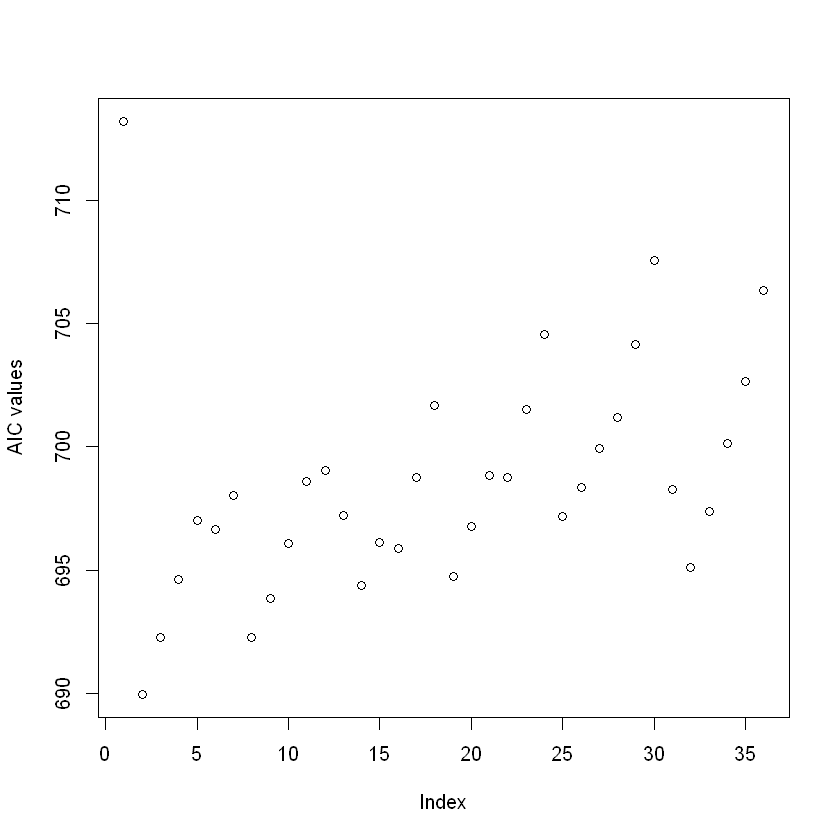

In [11]:
aicv = as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1
print(porder)
print(qorder)

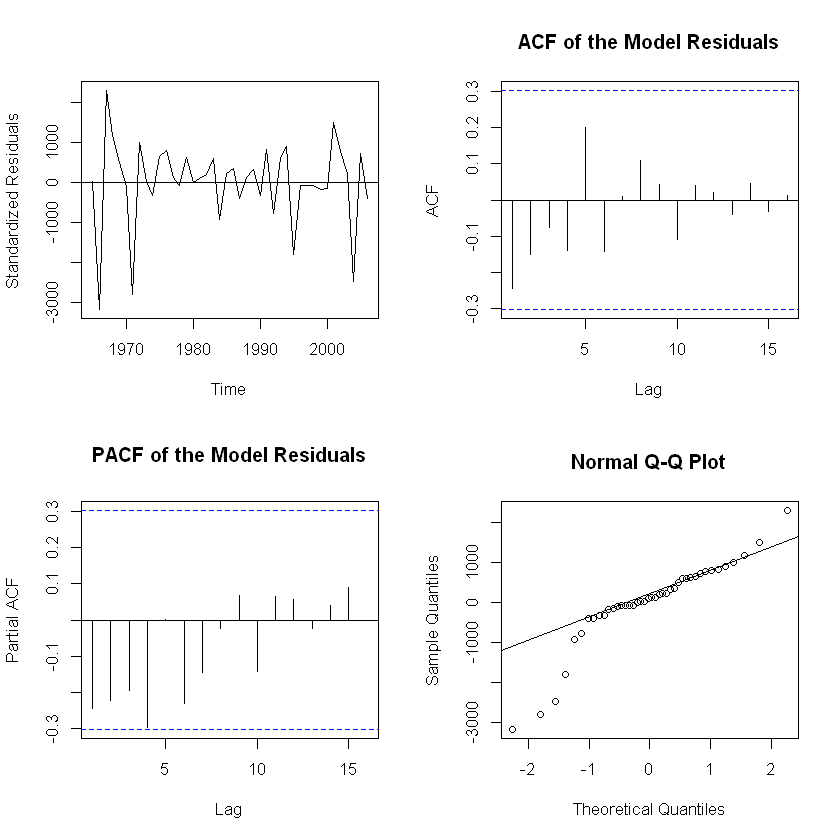

In [12]:
final_model.2 = arima(ts_totalMoose, order = c(porder,1,qorder), method = "ML")
resids.2 = resid(final_model.2)
## Residual Analysis
par (mfrow=c(2,2))
plot(resids.2, ylab='Standardized Residuals')
abline(h=0)
acf(resids.2,main= 'ACF of the Model Residuals')
pacf(resids.2,main='PACF of the Model Residuals')
qqnorm(resids.2)
qqline(resids.2)

In [13]:
Box.test(resids.2, lag = (porder+qorder+1), fitdf = (porder+qorder))


	Box-Pierce test

data:  resids.2
X-squared = 3.4275, df = 1, p-value = 0.06412


At 1% the residuals look like white noise from both Box test and Plots.

## Forecasting

In [14]:
## Forecasting with ARIMA 
## 4 Years Ahead: 
outtotal = arima(ts_totalMoose[1:nfit], order = c(porder,1,qorder),method = "ML")
final.pred.2 = predict(outtotal,n.ahead=4)$pred

# Both forecast approaches visualized 

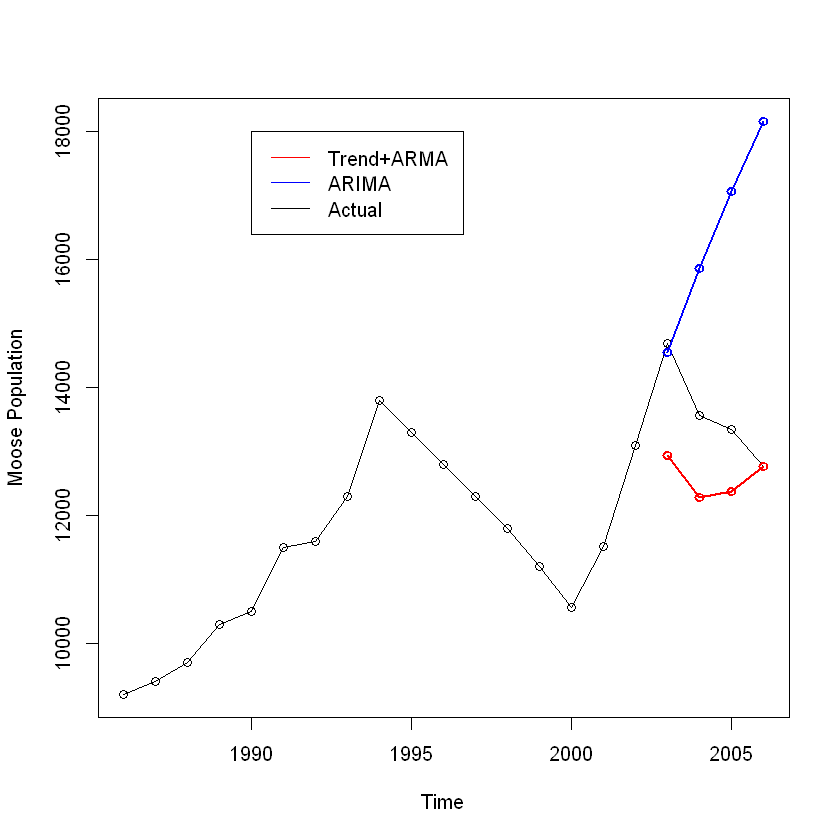

In [21]:
ymin = min(c(ts_totalMoose[(n-20):n],final.pred.1,final.pred.2))
ymax = max(c(ts_totalMoose[(n-20):n],final.pred.1,final.pred.2))
plot(years[(n-20):n], ts_totalMoose[(n-20):n],type="o", ylim=c(ymin,ymax), xlab="Time", ylab="Moose Population")
lines(years[(nfit+1):n],final.pred.1,col="red",lwd=2, type="o")
lines(years[(nfit+1):n],final.pred.2,col="blue",lwd=2,  type="o")
legend(1990,18000,legend=c("Trend+ARMA","ARIMA","Actual"),col=c("red","blue","black"),lty=1)

### Take home message:

Limitations: <br>
<li>ARIMA modeling is easy to implement but it captures the non-stationarity assuming similarity among prior observations and thus it can mispredict if changes in the trend are seen. HENCE, Prediction using ARIMA can perform well if only short time prediction periods are considered. <br>
<li>Trend+ARMA estimation is more difficult to implement, particularly if interested in obtaining confidence bands too, but it can capture long-memory trend 